## 1.Importing Packages

In [1]:
import os
import re
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import read_data
from user_agents import parse

## 2. Reading the data

In [2]:
df = read_data("output.log")
df.head()

Skipping line 601730: Expected 7 fields in line 601730, saw 23. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


,ip,time,request,status_code,response_length,user_agent,response_time
0,207.213.193.143,[2021-5-12T5:6:0.0+0430],[Get /cdn/profiles/1026106239],304,0,[[Googlebot-Image/1.0]],32.0
1,207.213.193.143,[2021-5-12T5:6:0.0+0430],[Get images/badge.png],304,0,[[Googlebot-Image/1.0]],4.0
2,35.110.222.153,[2021-5-12T5:6:0.0+0430],[Get /pages/630180847],200,52567,[[Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG S...,32.0
3,35.108.208.99,[2021-5-12T5:6:0.0+0430],[Get images/fav_icon2.ico],200,23531,[[Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Ap...,20.0
4,35.110.222.153,[2021-5-12T5:6:0.0+0430],[Get images/sanjagh_logo_purpule5.png],200,4680,[[Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG S...,8.0


In [3]:
df.shape

(1260034, 7)

## 3. Exploring the Data

### 3.1. Cleaning the data

#### 3.1.1. Removing the bracets from time, request, user_agent columns

In [4]:
for col in ["time", "request", "user_agent"]:
    df[col] = df[col].apply(lambda x : x.strip("[]"))

#### 3.1.2. Converting the type of time column to datetime

In [5]:
df["time"] = pd.to_datetime(df["time"])

#### 3.1.3. Extracting the methods from requests

In [6]:
df["method"] = df["request"].apply(lambda x: x.split()[0])

#### 3.1.4.  Creating a new column for paths and removing the request column

In [7]:
df["path"] = df["request"].apply(lambda x: x.split()[1])
df.drop(columns=["request"], inplace=True)
df["path"] = df["path"].apply(lambda x: x.strip("/"))

#### 3.1.5. Reordering the columns for better readability

In [8]:
df = df.reindex(columns = ["ip", "time", "method", "path", "status_code", "response_length", "user_agent", "response_time"])
df.head(3)

,ip,time,method,path,status_code,response_length,user_agent,response_time
0,207.213.193.143,2021-05-12 05:06:00+04:30,Get,cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32.0
1,207.213.193.143,2021-05-12 05:06:00+04:30,Get,images/badge.png,304,0,Googlebot-Image/1.0,4.0
2,35.110.222.153,2021-05-12 05:06:00+04:30,Get,pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32.0


### 3.2. Missing values

In [9]:
df.isnull().sum()

ip                 18090
time                   0
method                 0
path                   0
status_code            0
response_length        0
user_agent             0
response_time      19808
dtype: int64

In [10]:
ip_null_df = df[df["ip"].isnull()]
ip_null_df.head()

,ip,time,method,path,status_code,response_length,user_agent,response_time
25,NaN,2021-05-12 05:06:01+04:30,Get,,301,169,kube-probe/1.21,NaN
85,NaN,2021-05-12 05:06:03+04:30,Get,,301,169,kube-probe/1.21,NaN
145,NaN,2021-05-12 05:06:05+04:30,Get,,301,169,kube-probe/1.21,NaN
175,NaN,2021-05-12 05:06:07+04:30,Get,,301,169,kube-probe/1.21,NaN
215,NaN,2021-05-12 05:06:09+04:30,Get,,301,169,kube-probe/1.21,NaN


In [11]:
ip_null_df["time"].value_counts()

2021-05-12 05:06:01+04:30    1
2021-05-12 11:47:53+04:30    1
2021-05-12 11:48:05+04:30    1
2021-05-12 11:48:03+04:30    1
2021-05-12 11:48:01+04:30    1
                            ..
2021-05-12 08:27:15+04:30    1
2021-05-12 08:27:17+04:30    1
2021-05-12 08:27:19+04:30    1
2021-05-12 08:27:21+04:30    1
2021-05-12 15:08:59+04:30    1
Name: time, Length: 18090, dtype: int64

In [12]:
ip_null_df["response_time"].value_counts()

Series([], Name: response_time, dtype: int64)

In [13]:
ip_null_df["method"].value_counts()

Get    18090
Name: method, dtype: int64

In [14]:
ip_null_df["path"].value_counts()

    18090
Name: path, dtype: int64

In [15]:
ip_null_df["status_code"].value_counts()

301    18090
Name: status_code, dtype: int64

In [16]:
ip_null_df["response_length"].value_counts()

169    18090
Name: response_length, dtype: int64

In [17]:
ip_null_df["user_agent"].value_counts()

kube-probe/1.21    18090
Name: user_agent, dtype: int64

#### 3.2.1. Let's remove this part of data from the original dataset and keep them seprately 

In [18]:
df.drop(ip_null_df.index, inplace=True)

In [19]:
df.isnull().sum()

ip                    0
time                  0
method                0
path                  0
status_code           0
response_length       0
user_agent            0
response_time      1718
dtype: int64

In [20]:
df[df["response_time"].isnull()].head()

,ip,time,method,path,status_code,response_length,user_agent,response_time
776,20.62.177.11,2021-05-12 05:06:31+04:30,Get,pros/1993352776,200,53479,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
2010,20.62.177.60,2021-05-12 05:07:27+04:30,Get,pros/1797822247,200,55330,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
2708,20.62.177.133,2021-05-12 05:08:04+04:30,Get,pros/763244865,200,20947,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
2866,207.213.193.118,2021-05-12 05:08:18+04:30,Get,pages/1939232229,301,169,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,NaN
3468,20.62.177.4,2021-05-12 05:08:49+04:30,Get,pros/2084824811,200,37060,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN


#### 3.2.2 Let's replace these Nan values with 999 

In [21]:
print("Minimum of response_time", min(df["response_time"].unique()))
print("Maximum of response_time", max(df["response_time"].unique()))

Minimum of response_time 0.0
Maximum of response_time 175047044.0


In [22]:
if 999 not in df["response_time"].unique():
    df["response_time"] = df["response_time"].fillna(999)
else:
    print("999 is in response_time")
    

In [23]:
df.isnull().sum()

ip                 0
time               0
method             0
path               0
status_code        0
response_length    0
user_agent         0
response_time      0
dtype: int64

In [24]:
df[df["path"] == ""]

,ip,time,method,path,status_code,response_length,user_agent,response_time
155,20.117.146.75,2021-05-12 05:06:06+04:30,Get,,307,0,Go-http-client/2.0,4.0
360,20.92.247.170,2021-05-12 05:06:13+04:30,Get,,307,0,Go-http-client/2.0,8.0
622,76.212.164.3,2021-05-12 05:06:24+04:30,Get,,307,0,Go-http-client/2.0,0.0
645,93.113.99.115,2021-05-12 05:06:25+04:30,Get,,307,0,Go-http-client/2.0,12.0
828,36.67.23.210,2021-05-12 05:06:36+04:30,Get,,307,0,Go-http-client/2.0,12.0
...,...,...,...,...,...,...,...,...
1259000,20.92.247.170,2021-05-12 15:08:25+04:30,Get,,307,0,Go-http-client/2.0,4.0
1259140,93.113.99.115,2021-05-12 15:08:28+04:30,Get,,307,0,Go-http-client/2.0,8.0
1259155,238.129.28.160,2021-05-12 15:08:29+04:30,Get,,307,0,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,4.0
1259505,60.148.0.167,2021-05-12 15:08:41+04:30,Get,,307,0,Go-http-client/2.0,4.0


In [25]:
df[df["path"] == ""]["method"].unique()

array(['Get', 'Head'], dtype=object)

In [26]:
df[df["path"] == ""]["status_code"].unique()

array([307, 405, 301, 499], dtype=int64)

In [27]:
df[df["path"] == ""]["response_length"].unique()

array([  0, 169], dtype=int64)

In [28]:
df[df["path"] == ""]["user_agent"].nunique()

321

In [29]:
df[df["path"] == ""]["ip"].nunique()

579

### 3.3. Graphs

#### 3.3.1. The most common IP addresses

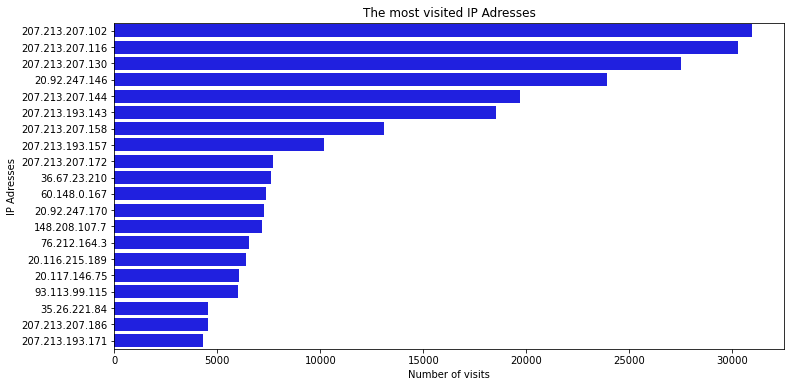

In [30]:
plt.figure(figsize=(12,6))
sns.countplot(y="ip", data = df, order = df["ip"].value_counts().head(20).index, color ="b")
plt.title("The most visited IP Adresses")
plt.ylabel("IP Adresses")
plt.xlabel("Number of visits")
plt.show()

#### 3.3.2. The most requested methods

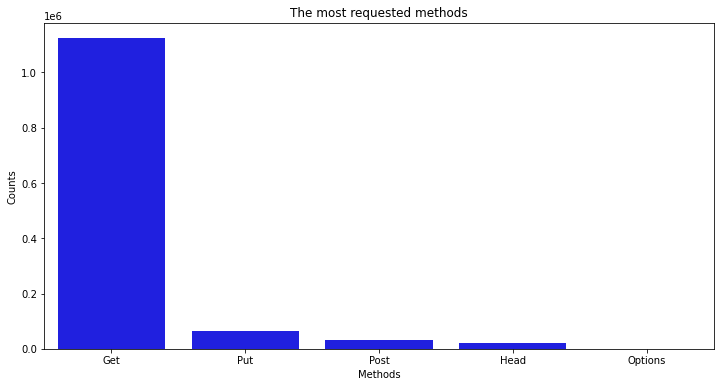

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(x="method", data = df, order = df["method"].value_counts().head(20).index, color ="b")
plt.title("The most requested methods")
plt.xlabel("Methods")
plt.ylabel("Counts")
plt.show()

#### 3.3.3 The most visited paths

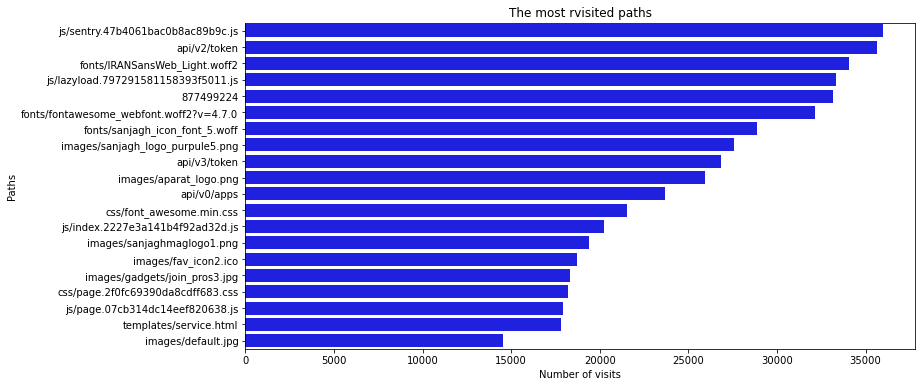

In [32]:
plt.figure(figsize=(12,6))
sns.countplot(y="path", data = df, order = df["path"].value_counts().head(20).index, color ="b")
plt.title("The most rvisited paths")
plt.ylabel("Paths")
plt.xlabel("Number of visits")
plt.show()

#### 3.3.4. The most status_codes

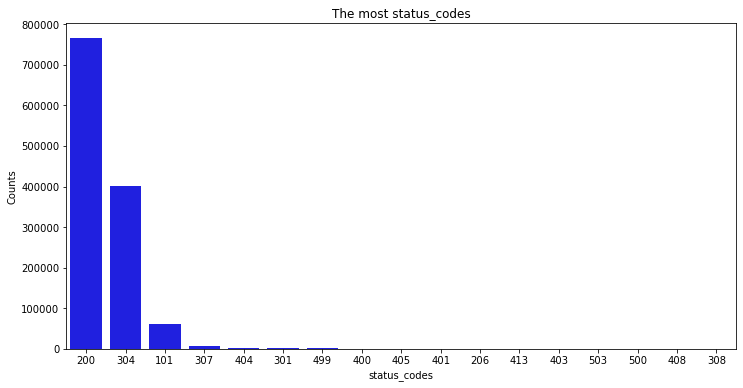

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(x="status_code", data = df, order = df["status_code"].value_counts().head(20).index, color ="b")
plt.title("The most status_codes")
plt.xlabel("status_codes")
plt.ylabel("Counts")
plt.show()

#### Statuus code meaning:
#### 200: “Everything is OK.” This is the code that is delivered when a web page or resource acts exactly the way it’s expected to.
#### 304: “The requested resource has not been modified since the last time you accessed it.” This code tells the browser that the   resources stored in the browser cache haven’t changed. It’s used to speed up web page delivery by reusing previously downloaded resources
#### 101: “Switching protocols.” Your browser has asked the server to change protocols, and the server has complied.
#### 307: “Temporary Redirect.” This status code has replaced 302 “Found” as the appropriate action when a resource has been  temporarily moved to a different URL. Unlike the 302 status code, it does not allow the HTTP method to change.
#### 404: “The requested resource was not found.” This is the most common error message of them all. This code means that the requested resource does not exist, and the server does not know if it ever existed.
#### 301: “The requested resource has been moved permanently.” This code is delivered when a web page or resource has been permanently replaced with a different resource. It is used for permanent URL redirection.
#### 499: “Client closed request.” This is returned by NGINX when the client closes the request while Nginx is still processing it.

#### 3.3.5. User agents components (https://pypi.org/project/user-agents/)

#### User agent tells the server what the visiting device is. 
#### Every device type, including phones, tablets, desktops, may come with its own UA that makes it possible to detect this device for any purpose. Interestingly bots and crawlers also come with their unique UAs.
 

In [34]:
df["browser"] = df['user_agent'].apply(lambda x: parse(x).browser.family)

In [35]:
df["os"] = df['user_agent'].apply(lambda x: parse(x).os.family)

In [36]:
df["is_pc"] = df['user_agent'].apply(lambda x: parse(x).is_pc)

In [37]:
df["is_bot"] = df['user_agent'].apply(lambda x: parse(x).is_bot)

In [38]:
df.head()

,ip,time,method,path,status_code,response_length,user_agent,response_time,browser,os,is_pc,is_bot
0,207.213.193.143,2021-05-12 05:06:00+04:30,Get,cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32.0,Googlebot-Image,Other,False,True
1,207.213.193.143,2021-05-12 05:06:00+04:30,Get,images/badge.png,304,0,Googlebot-Image/1.0,4.0,Googlebot-Image,Other,False,True
2,35.110.222.153,2021-05-12 05:06:00+04:30,Get,pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32.0,Samsung Internet,Android,False,False
3,35.108.208.99,2021-05-12 05:06:00+04:30,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20.0,Chrome Mobile,Android,False,False
4,35.110.222.153,2021-05-12 05:06:00+04:30,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8.0,Samsung Internet,Android,False,False


##### 3.3.5.1. The most used browsers

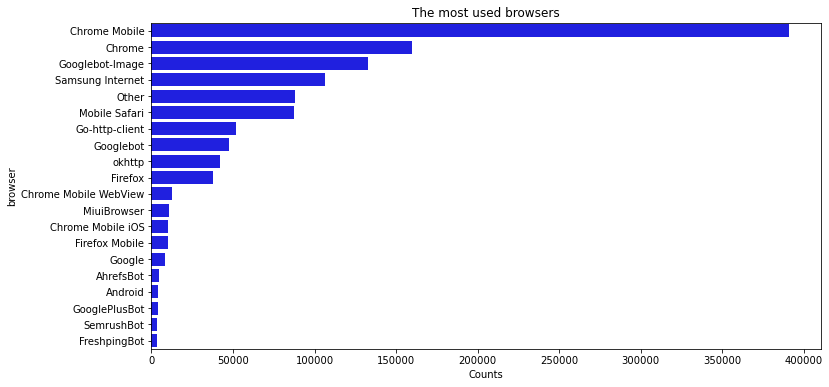

In [39]:
plt.figure(figsize=(12,6))
sns.countplot(y="browser", data = df, order = df["browser"].value_counts().head(20).index, color ="b")
plt.title("The most used browsers")
plt.ylabel("browser")
plt.xlabel("Counts")
plt.show()

In [40]:
print("Number of unique browsers: ", df["browser"].nunique())

Number of unique browsers:  80


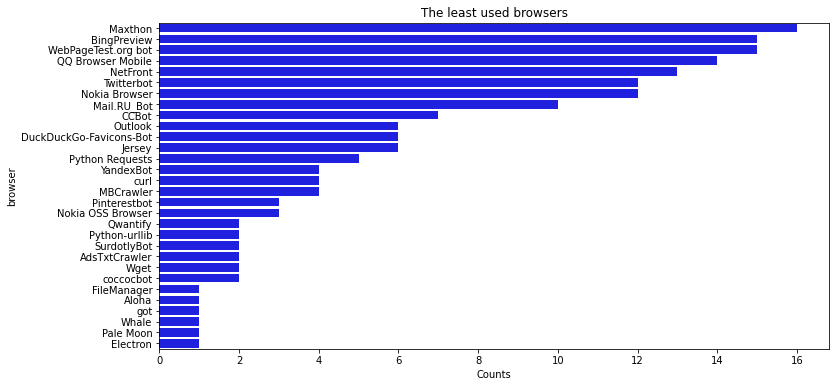

In [41]:
plt.figure(figsize=(12,6))
sns.countplot(y="browser", data = df, order = df["browser"].value_counts().tail(30).index, color ="b")
plt.title("The least used browsers")
plt.ylabel("browser")
plt.xlabel("Counts")
plt.show()

##### 3.3.5.2 The most used OS

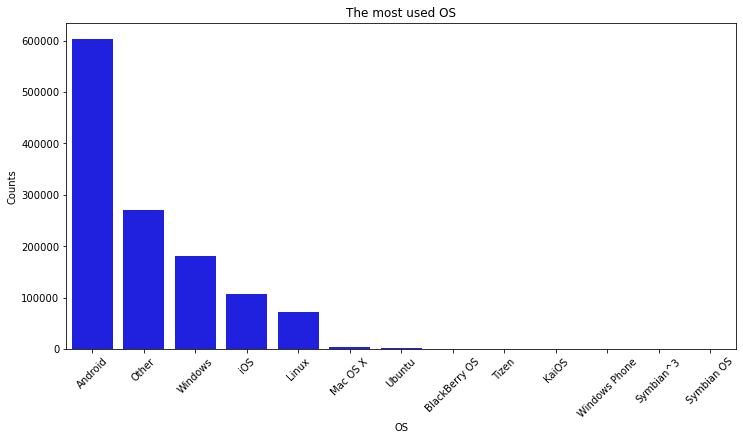

In [42]:
plt.figure(figsize=(12,6))
sns.countplot(x="os", data = df, order = df["os"].value_counts().head(20).index, color ="b")
plt.title("The most used OS")
plt.xlabel("OS")
plt.xticks(rotation = 45)
plt.ylabel("Counts")
plt.show()

In [43]:
print("Number of unique OS: ", df["os"].nunique())

Number of unique OS:  13


##### 3.3.5.3 Distribution of PCs and Bots

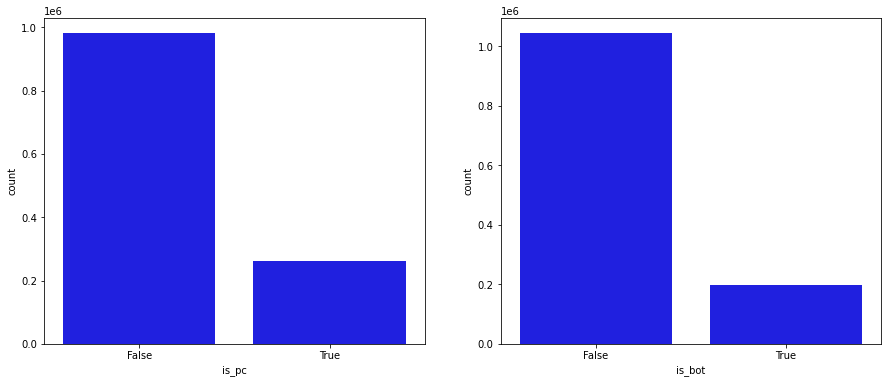

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
axes = ax.ravel()
sns.countplot(x="is_pc", data = df, order = df["is_pc"].value_counts().head(20).index, color ="b", ax=axes[0])
sns.countplot(x="is_bot", data = df, order = df["is_bot"].value_counts().head(20).index, color ="b", ax=axes[1])
plt.show()

#### 3.3.6 Response time and Response lenght 

### their unit????

In [45]:
df.response_length.describe()

count    1.241944e+06
mean     4.647441e+04
std      3.374295e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.201000e+03
75%      2.741100e+04
max      1.022335e+08
Name: response_length, dtype: float64

In [46]:
df.response_time.describe()

count    1.241944e+06
mean     6.811141e+03
std      1.844408e+05
min      0.000000e+00
25%      4.000000e+00
50%      1.200000e+01
75%      2.400000e+01
max      1.750470e+08
Name: response_time, dtype: float64

In [48]:
df.shape

(1241944, 12)

In [47]:
# df.to_csv("../input/processed_output_log.csv", index=False)